# Loading Data and Glance

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('always')

fake = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv")
true = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/True.csv")

In [2]:
print("Fake News Dataset Shape:", fake.shape)
print("True News Dataset Shape:", true.shape)


Fake News Dataset Shape: (23481, 4)
True News Dataset Shape: (21417, 4)


In [3]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
# Concat two data frames together 

fake["label"] = 0  # 0 = Fake
true["label"] = 1  # 1 = Real

df = pd.concat([fake, true], axis=0)


In [6]:
print(df.isnull().sum())


title      0
text       0
subject    0
date       0
label      0
dtype: int64


* There is no null value.That's what make us happy.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


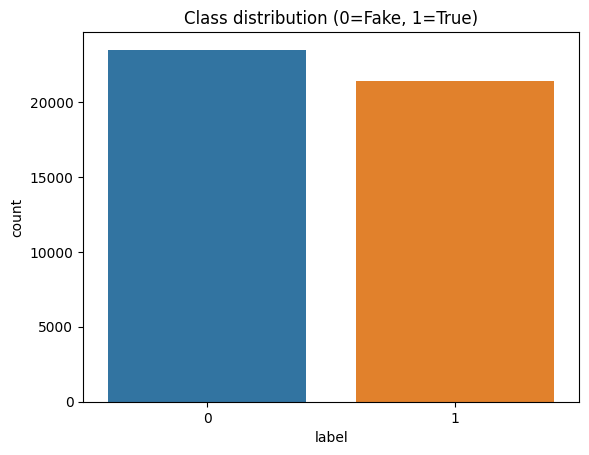

In [7]:
sns.countplot(x="label", data=df)
plt.title("Class distribution (0=Fake, 1=True)")
plt.show()

* As it's clear, fake and true label distributions are equal. That makes a any Ml model works properly

# Preprocessing

In [8]:
# add dependency
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re


In [9]:
# download resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [10]:
# uppercase to lowercase
df["text"] = df["text"].str.lower()

# deleting link and stuff XD
df["text"] = df["text"].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x))  
df["text"] = df["text"].apply(lambda x: re.sub(r'\d+', '', x))  
df["text"] = df["text"].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))  

In [11]:
# delete stopwords
stop_words = set(stopwords.words('english'))
df["text"] = df["text"].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [12]:
# Lemmatization
lemmatizer = WordNetLemmatizer()
df["text"] = df["text"].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

In [13]:
df["text"].head()


0    donald trump wish american happy new year leav...
1    house intelligence committee chairman devin nu...
2    friday revealed former milwaukee sheriff david...
3    christmas day donald trump announced would bac...
4    pope francis used annual christmas day message...
Name: text, dtype: object

# Choosing Model

- In this section, I tried to examine different models and work on the winner one 

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings("ignore")

# We have to input 'text' as the only input to the models --> prevent data leakage 
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)

vectorizer = TfidfVectorizer(max_df=0.7)
tfidf_train = vectorizer.fit_transform(X_train)
tfidf_test = vectorizer.transform(X_test)

models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Linear SVC": LinearSVC(),
    "Multinomial NB": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results = []

for name, model in models.items():
    model.fit(tfidf_train, y_train)
    y_pred = model.predict(tfidf_test)
    acc = accuracy_score(y_test, y_pred)
    results.append({"Model": name, "Accuracy": acc})
    print(f"{name}:", classification_report(y_test, y_pred))

results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
print("Model Comparison:")
print(results_df)


Logistic Regression:               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4696
           1       0.98      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

Linear SVC:               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4696
           1       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

Multinomial NB:               precision    recall  f1-score   support

           0       0.97      0.94      0.95      4696
           1       0.93      0.97      0.95      4284

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95  

# Testing Data Leakage

- If in text, there are any specific words for each fake or true news,there is chance of data leakage

In [15]:
from collections import Counter

fake_words = Counter(" ".join(df[df["label"]==0]["text"]).split())
real_words = Counter(" ".join(df[df["label"]==1]["text"]).split())

exclusive_fake = set(fake_words) - set(real_words)
exclusive_real = set(real_words) - set(fake_words)

print("Fake sample words:", list(exclusive_fake)[:20])
print("Real sample words :", list(exclusive_real)[:20])





Fake sample words: ['pictwittercomezxusrcsl', 'belowabdullahi', 'answersnow', 'saidralph', 'politicsclick', 'milleraccording', 'extrovert', 'stengel', 'claimswell', 'internetit', 'embarrassthe', 'timesdane', 'steelwe', 'waystrump', 'interestcandidate', 'ftr', 'clearby', 'lookeven', 'oswaldciamafialinked', 'saturdaytrump']
Real sample words : ['“haven’t', 'secondleastpopular', 'setree', 'imponderable', 'coalmine', 'africom', 'pouilly', 'molcaxac', '“broken', 'responsiblebut', 'existed”', 'doesburg', 'offbounds', 'roch', 'janos', 'scrubby', '“responsible', '“traditional', 'attitudes”', 'nastywomen']


- model memorize duplicated news

In [16]:
duplicates = df.duplicated(subset=["text"], keep=False)
print(" dup news :", duplicates.sum())


 dup news : 11426
